In [0]:
from google.colab import drive      #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd   #importing pandas
import numpy as np    #importing numpy
identity = pd.read_csv('/content/drive/My Drive/Fraud detection/train_identity.csv')   #reading identity data

In [0]:
print(f'identity has {identity.shape[0]} rows and {identity.shape[1]} columns')     #getting the rows and columns of dataset

identity has 144233 rows and 41 columns


In [0]:
transaction = pd.read_csv('/content/drive/My Drive/Fraud detection/train_transaction.csv')  #reading the transaction data

In [0]:
print(f'transaction has {transaction.shape[0]} rows and {transaction.shape[1]} columns')   #checking the rows and columns of transaction data

transaction has 590540 rows and 394 columns


In [0]:
train = pd.merge(transaction,identity, on ='TransactionID', how='left')   #merging transaction and identity data

In [0]:
print(f'train data has {train.shape[0]} rows and {train.shape[1]} columns')  #checking the shape of train data

train data has 590540 rows and 434 columns


In [0]:
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

In [0]:
train['transaction_day'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)

In [0]:
null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]

In [0]:
for i in train.columns:
    if train[i].dtypes=='int64' or train[i].dtypes=='float64':   #filling null alues with mean for continuous variables
        train[i].fillna(train[i].mean(),inplace=True)

In [0]:
for i in train.columns:
    if train[i].dtypes=='object':     #filling null alues with mode for categorical variables
        train[i].fillna(train[i].mode()[0],inplace=True)

In [0]:
#function to reduce the memory of dataset
   def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
cat_cols = ['id_12','id_15', 'id_16', 'id_23', 
            'id_27', 'id_28', 'id_29','id_30', 'id_31', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cat_cols:
  if i in train.columns:
    train[i] = le.fit_transform(train[i].astype(str).values)

In [0]:
train_vcol =[]
for i in range(1,340):
  train_vcol.append('V'+str(i))

In [0]:
vcol=train[train_vcol]

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(vcol)
  

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
vcol1=pca.transform(vcol)

In [0]:
train.drop(vcol,axis=1,inplace=True)

In [0]:
vcol1 = pd.DataFrame(vcol1)

In [0]:
train=pd.concat([train,vcol1],axis=1)

In [0]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 455.05 MB
Memory usage after optimization is: 107.00 MB
Decreased by 76.5%


In [0]:
y= train['isFraud']
print(y.shape)

(590540,)


In [0]:
x = train.drop(['isFraud','TransactionID','TransactionDT'],axis=1)
print(x.shape)

(590540, 97)


In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify = y,test_size = 0.3, random_state=1)

##DECISION TREE CLASSIFIER

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1)
model.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [0]:
predict = model.predict(x_test)

In [0]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(y_test,predict)

0.7743714560264565

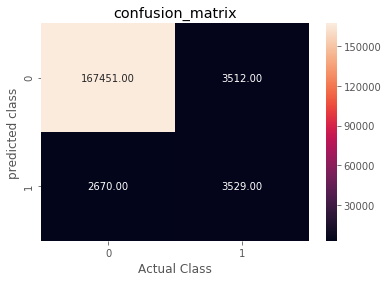

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f')
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

##AdaBoost Classifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
acc = []
roc= []
for i in np.arange(50,500,step=50):
  classifier = AdaBoostClassifier(
      model,
      n_estimators= i 
  )
  classifier.fit(x_train, y_train)
  predict=classifier.predict(x_test)
  acc.append(classifier.score(x_test,y_test))
  roc.append(roc_auc_score(y_test,predict))

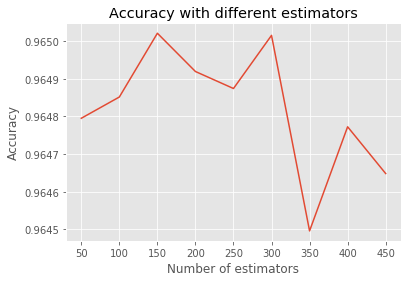

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
plt.xticks(np.arange(0,9,step=1),np.arange(50,500,step=50))
plt.title('Accuracy with different estimators')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.plot(acc)
plt.show()

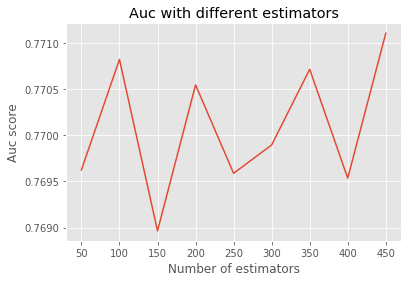

In [0]:
import matplotlib.pyplot as plt
plt.plot(roc)   
plt.xticks(np.arange(0,9,step=1),np.arange(50,500,step=50))
plt.title('Auc with different estimators')
plt.xlabel('Number of estimators')
plt.ylabel('Auc score')
plt.show()

As we can see from above graph our model achives highest auc score with 500 estimators.

In [0]:
classifier = AdaBoostClassifier( model,n_estimators=500,random_state=1)
classifier.fit(x_train, y_train)
predict=classifier.predict(x_test)

In [0]:
predictions = classifier.predict(x_test)

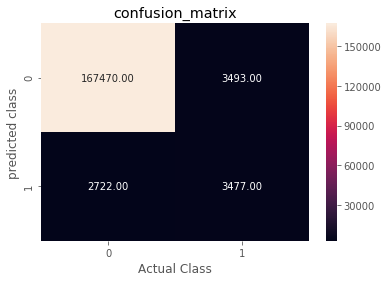

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f')
plt.title('confusion_matrix')         #checking the confusion matrix
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

In [0]:
roc_auc_score(y_test,predictions)

0.7702327987304264